In [1]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00


In [2]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel,RFE
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import warnings
from sklearn.decomposition import PCA
import optuna
from imblearn.pipeline import Pipeline as imblearn_Pipeline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [5]:
df = pd.read_csv("/content/drive/MyDrive/MS DATA SCIENCE /TESE /data_processed_selected.csv")
w2v= KeyedVectors.load_word2vec_format('/content/drive/MyDrive/MS DATA SCIENCE /TESE /skip_s600_word2vec.txt')

In [6]:
# df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
# w2v= KeyedVectors.load_word2vec_format('D:\\MS DATA SCIENCE\\NLP TESE\\embeddings\\skip_s600_word2vec.txt')

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
def preprocess_entities(row):
    if pd.isna(row)==False:
        entities = row.lower()  # Convert to lowercase
        entities = entities.replace(',', '')  # Remove commas
        entities = ' '.join(set(entities.split()))  # Convert to set to get unique values, then join back as a string
        return entities
df['entities'] = df['entities'].apply(preprocess_entities)

In [9]:
y=df['reason']
X = df[['narrative_embeddings', 'embeddings_title', 'embeddings_keywords', 'events_embeddings', 'entities']]

In [10]:
# Split the data into a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 5)
y_train shape: (15701,)
X_test shape: (6729, 5)
y_test shape: (6729,)


In [11]:
def embeddings_transformation(X, model):
    '''returns the mean of the embeddings of the document X'''
    # initiating a sentence with all zeros
    embedding_size = 600
    X_transformed = np.zeros((len(X), embedding_size))

    # Loop over each string in X
    for i, sentence in enumerate(X):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_transformed[i] = np.mean(embeddings, axis=0)
    return X_transformed

In [12]:
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_selected = X_train[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
# Transform the text data into embeddings
X_train_embeddings = embeddings_transformation(X_train_selected, w2v)

In [13]:
def cross_validate_with_pipeline(pipeline, X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_true_labels = []
    all_predicted_labels = []

    for fold, (train_index, val_index) in enumerate(kf.split(X, y), start=1):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        pipeline.fit(X_train_fold, y_train_fold)

        y_pred_train = pipeline.predict(X_train_fold)
        y_pred_val = pipeline.predict(X_val_fold)

        training_f1_macro = f1_score(y_train_fold, y_pred_train, average='macro')
        validation_f1_macro = f1_score(y_val_fold, y_pred_val, average='macro')

        print(f"Fold number: {fold}, Training F1 Macro: {training_f1_macro:.4f}, Validation F1 Macro: {validation_f1_macro:.4f}")

        all_true_labels.extend(y_val_fold)
        all_predicted_labels.extend(y_pred_val)

    return all_true_labels, all_predicted_labels

In [14]:
def compute_mean_f1_macro(pipeline, X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_true_labels = []
    all_predicted_labels = []

    for fold, (train_index, val_index) in enumerate(kf.split(X, y), start=1):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        pipeline.fit(X_train_fold, y_train_fold)

        y_pred_val = pipeline.predict(X_val_fold)

        all_true_labels.extend(y_val_fold)
        all_predicted_labels.extend(y_pred_val)

    mean_f1_macro = f1_score(all_true_labels, all_predicted_labels, average='macro')

    return mean_f1_macro

In [15]:
def plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels):
    # Generate the confusion matrix
    confusion_mat = confusion_matrix(all_true_labels, all_predicted_labels, labels=class_labels)

    # Calculate the classification report
    class_report = classification_report(all_true_labels, all_predicted_labels, target_names=[f'Class {label}' for label in class_labels])

    print("\nClassification Report:")
    print(class_report)

    # Plot the confusion matrix
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i, s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=10)
    plt.show()
    print('\n')

In [16]:
import os

# Get the number of CPU cores
num_cpus = os.cpu_count()

print("Number of CPU cores available:", num_cpus)

Number of CPU cores available: 12


In [17]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    # Get the GPU IDs
    gpu_ids = list(range(num_gpus))
    print(f"GPU IDs: {gpu_ids}")
else:
    print("No GPUs available.")


Number of GPUs available: 1
GPU IDs: [0]


# XGBOOST    
was slightly better than LinearSVC in terms of F1-Score, by 1%

<span style="color:white; font-size:18px;background-color:red"> HYPERPARAMETER TUNING </span>  

In [19]:
def objective(trial):
  # Define the hyperparameter search space
  new_params= {
    'max_depth': trial.suggest_int('max_depth', 3, 12),
    'eta': trial.suggest_loguniform('eta', 0.001, 0.3),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
    'n_estimators': trial.suggest_int('n_estimators', 50, 400),
    'gamma': trial.suggest_float('gamma', 0, 1),
    'alpha': trial.suggest_float('alpha', 0, 100),  # L1 regularization term on weights
    'lambda': trial.suggest_float('lambda', 0, 100) # L2
    }

  # Create and train the XGBoost classifier with the current set of hyperparameters
  model = XGBClassifier(
    random_state=42,
    num_class=4,
    n_jobs=-1,
    objective='multi:softmax',
    eval_metric='mlogloss',
    tree_method='gpu_hist',  # Use GPU acceleration
    gpu_id=0,                # Specify GPU device 0
    **new_params
)

  pipeline = Pipeline([
      ('classifier', model)
      ])

  mean_f1_scores= compute_mean_f1_macro(pipeline, X_train_embeddings, y_train, n_splits=5)
  return mean_f1_scores

In [20]:
import os
path = '/content/drive/MyDrive/MS DATA SCIENCE /TESE /optimização/new'
# database_filename = 'xgboost_w2v_expanded.db'
database_filename = 'xgboost_w2v_gpu.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [21]:
# create study
study = optuna.create_study(storage=storage, direction='maximize', study_name='xgboost_w2v_gpu',load_if_exists=True)
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2023-09-21 22:27:31,656] A new study created in RDB with name: xgboost_w2v_gpu
[I 2023-09-21 22:28:36,529] Trial 8 finished with value: 0.35722348045643415 and parameters: {'max_depth': 3, 'eta': 0.2549043891247123, 'subsample': 0.5492039733175792, 'colsample_bytree': 0.8698118993258679, 'min_child_weight': 5, 'n_estimators': 181, 'gamma': 0.02134968796622383, 'alpha': 73.42700782974099, 'lambda': 25.938233387940357}. Best is trial 8 with value: 0.35722348045643415.
[I 2023-09-21 22:28:41,374] Trial 7 finished with value: 0.3072042561687248 and parameters: {'max_depth': 3, 'eta': 0.0021191937373649483, 'subsample': 0.804583252262558, 'colsample_bytree': 0.9975315007370706, 'min_child_weight': 11, 'n_estimators': 158, 'gamma': 0.8585577375303138, 'alpha': 81.83668640311662, 'lambda': 50.45437244367055}. Best is trial 8 with value: 0.35722348045643415.
[I 2023-09-21 22:28:46,574] Trial 6 finished with value: 0.34319735522222145 and parameters: {'max_depth': 9, 'eta': 0.087347760745328

In [22]:
study = optuna.load_study(study_name='xgboost_w2v_gpu', storage=storage)

# Fetch the number of completed trials
completed_trials = len(study.trials)

# Print the number of completed trials
print(f"Number of completed trials: {completed_trials}")

Number of completed trials: 50


In [23]:
study = optuna.load_study(study_name='xgboost_w2v_gpu', storage=storage)
trial = study.best_trial
print('F1 score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
# Plot the optimization history
import optuna.visualization as vis
vis.plot_optimization_history(study)

F1 score: 0.44209634791173313
Best hyperparameters: {'max_depth': 10, 'eta': 0.1968891060188219, 'subsample': 0.7101907258770195, 'colsample_bytree': 0.7342706638436639, 'min_child_weight': 13, 'n_estimators': 252, 'gamma': 0.672652534722509, 'alpha': 23.311271459881095, 'lambda': 17.31261620201332}


Fold number: 1, Training F1 Macro: 0.7700, Validation F1 Macro: 0.4468
Fold number: 2, Training F1 Macro: 0.7773, Validation F1 Macro: 0.4487
Fold number: 3, Training F1 Macro: 0.7728, Validation F1 Macro: 0.4378
Fold number: 4, Training F1 Macro: 0.7753, Validation F1 Macro: 0.4278
Fold number: 5, Training F1 Macro: 0.7722, Validation F1 Macro: 0.4487

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.58      0.64      0.61      5576
     Class 1       0.36      0.07      0.11      1553
     Class 2       0.72      0.84      0.77      7510
     Class 3       0.47      0.20      0.28      1062

    accuracy                           0.65     15701
   macro avg       0.53      0.44      0.44     15701
weighted avg       0.61      0.65      0.61     15701

Confusion Matrix:


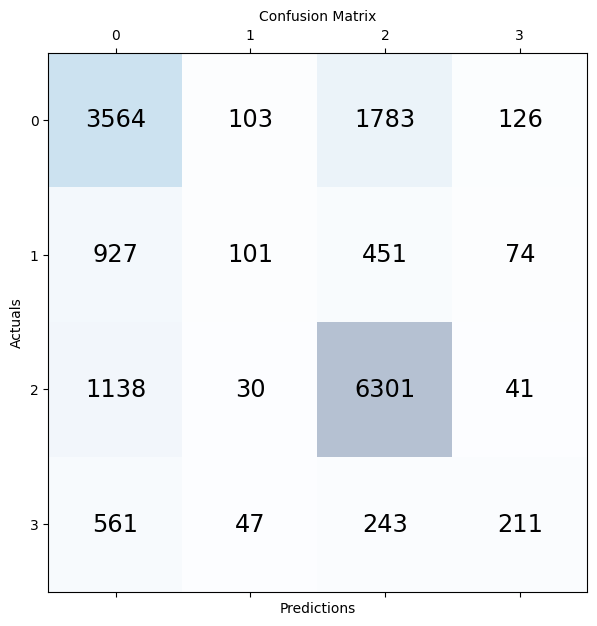

In [25]:
params= trial.params

best_model = XGBClassifier(
    random_state=42,
    num_class=4,
    n_jobs=-1,
    objective='multi:softmax',
    eval_metric='mlogloss',
    tree_method='gpu_hist',  # Use GPU acceleration
    gpu_id=0,                # Specify GPU device 0
    **params
)

pipeline = Pipeline([
    ('classifier', best_model)
])

all_true_labels, all_predicted_labels= cross_validate_with_pipeline(pipeline,X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

Fold number: 1, Training F1 Macro: 0.9997, Validation F1 Macro: 0.4134
Fold number: 2, Training F1 Macro: 0.9999, Validation F1 Macro: 0.4279
Fold number: 3, Training F1 Macro: 1.0000, Validation F1 Macro: 0.3915
Fold number: 4, Training F1 Macro: 0.9998, Validation F1 Macro: 0.4155
Fold number: 5, Training F1 Macro: 0.9998, Validation F1 Macro: 0.4385

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.56      0.64      0.60      5576
     Class 1       0.34      0.05      0.09      1553
     Class 2       0.71      0.84      0.77      7510
     Class 3       0.51      0.14      0.22      1062

    accuracy                           0.64     15701
   macro avg       0.53      0.42      0.42     15701
weighted avg       0.61      0.64      0.60     15701

Confusion Matrix:


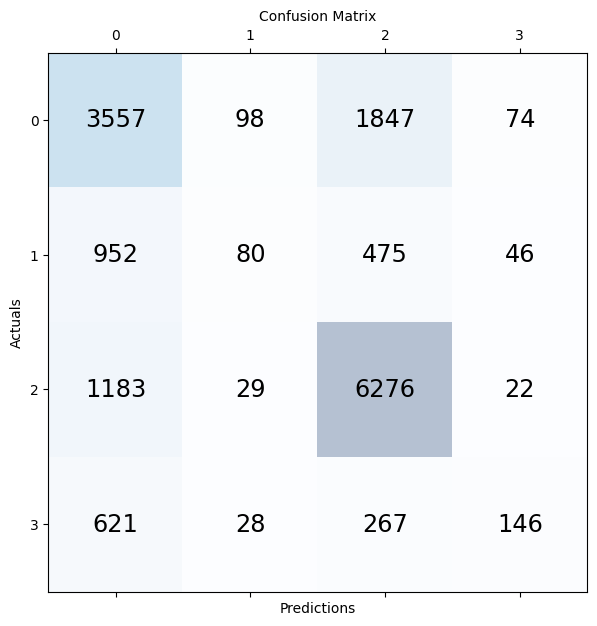

In [ ]:
# lets see if the base model was overfitting
model = XGBClassifier(random_state=42,
                           num_class=4,
                           n_jobs=-1,
                           objective='multi:softmax',
                           eval_metric='mlogloss')

pipeline = Pipeline([
    ('classifier', model)
])

all_true_labels, all_predicted_labels= cross_validate_with_pipeline(pipeline,X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> SMOTE + HT </span>  

In [26]:
import os
path = '/content/drive/MyDrive/MS DATA SCIENCE /TESE /optimização/new'
database_filename = 'xgboost_w2v_smote_gpu.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [27]:
def objective(trial):
  # Define the hyperparameter search space

  new_params= {
    'max_depth': trial.suggest_int('max_depth', 3, 12),
    'eta': trial.suggest_loguniform('eta', 0.001, 0.3),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
    'n_estimators': trial.suggest_int('n_estimators', 50, 400),
    'gamma': trial.suggest_float('gamma', 0, 1),
    'alpha': trial.suggest_float('alpha', 0, 100),  # L1 regularization term on weights
    'lambda': trial.suggest_float('lambda', 0, 100) # L2
    }

  # Create and train the XGBoost classifier with the current set of hyperparameters
  model = XGBClassifier(
    random_state=42,
    num_class=4,
    n_jobs=-1,
    objective='multi:softmax',
    eval_metric='mlogloss',
    tree_method='gpu_hist',  # Use GPU acceleration
    gpu_id=0,                # Specify GPU device 0
    **new_params
)

  smote=SMOTE(random_state=42, sampling_strategy='not majority')

  pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', model)
    ])

  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  all_true_labels = []
  all_predicted_labels = []

  for fold, (train_index, val_index) in enumerate(kf.split(X_train_embeddings, y_train), start=1):
      X_train_fold, X_val_fold = X_train_embeddings[train_index], X_train_embeddings[val_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

      pipeline.fit(X_train_fold, y_train_fold)

      y_pred_val = pipeline.predict(X_val_fold)

      all_true_labels.extend(y_val_fold)
      all_predicted_labels.extend(y_pred_val)

  mean_f1_macro = f1_score(all_true_labels, all_predicted_labels, average='macro')
  return mean_f1_macro

In [ ]:
# create study
study = optuna.create_study(storage=storage, direction='maximize', study_name='xgboost_w2v_smote_gpu',load_if_exists=True)
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2023-09-21 22:44:56,337] A new study created in RDB with name: xgboost_w2v_smote_gpu
[I 2023-09-21 22:46:39,430] Trial 8 finished with value: 0.384988644391704 and parameters: {'max_depth': 3, 'eta': 0.0013820080957252924, 'subsample': 0.996429595120978, 'colsample_bytree': 0.5719998307332672, 'min_child_weight': 3, 'n_estimators': 172, 'gamma': 0.08315072506090337, 'alpha': 54.73017858772664, 'lambda': 82.34572214675865}. Best is trial 8 with value: 0.384988644391704.
[I 2023-09-21 22:47:07,302] Trial 7 finished with value: 0.47497320326989206 and parameters: {'max_depth': 11, 'eta': 0.2949008556525883, 'subsample': 0.9646763869972765, 'colsample_bytree': 0.8197713590877833, 'min_child_weight': 15, 'n_estimators': 108, 'gamma': 0.841211759424437, 'alpha': 45.331501998075055, 'lambda': 52.8747540868177}. Best is trial 7 with value: 0.47497320326989206.
[I 2023-09-21 22:47:16,587] Trial 10 finished with value: 0.43795647454395426 and parameters: {'max_depth': 8, 'eta': 0.008183915536

In [29]:
study = optuna.load_study(study_name='xgboost_w2v_smote_gpu', storage=storage)
trial = study.best_trial
print('F1 score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
# Plot the optimization history
import optuna.visualization as vis
vis.plot_optimization_history(study)

F1 score: 0.4868784747393268
Best hyperparameters: {'max_depth': 9, 'eta': 0.09594313008862486, 'subsample': 0.706328486235277, 'colsample_bytree': 0.7882489349621931, 'min_child_weight': 8, 'n_estimators': 371, 'gamma': 0.7499975720323158, 'alpha': 41.40555535653485, 'lambda': 49.014154801585484}


Fold number: 1, Training F1 Macro: 0.9378, Validation F1 Macro: 0.4637
Fold number: 2, Training F1 Macro: 0.9378, Validation F1 Macro: 0.4731
Fold number: 3, Training F1 Macro: 0.9368, Validation F1 Macro: 0.4761
Fold number: 4, Training F1 Macro: 0.9421, Validation F1 Macro: 0.4776
Fold number: 5, Training F1 Macro: 0.9372, Validation F1 Macro: 0.4876

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.55      0.56      5576
     Class 1       0.27      0.19      0.22      1553
     Class 2       0.73      0.80      0.76      7510
     Class 3       0.36      0.35      0.36      1062

    accuracy                           0.62     15701
   macro avg       0.48      0.47      0.48     15701
weighted avg       0.60      0.62      0.61     15701

Confusion Matrix:


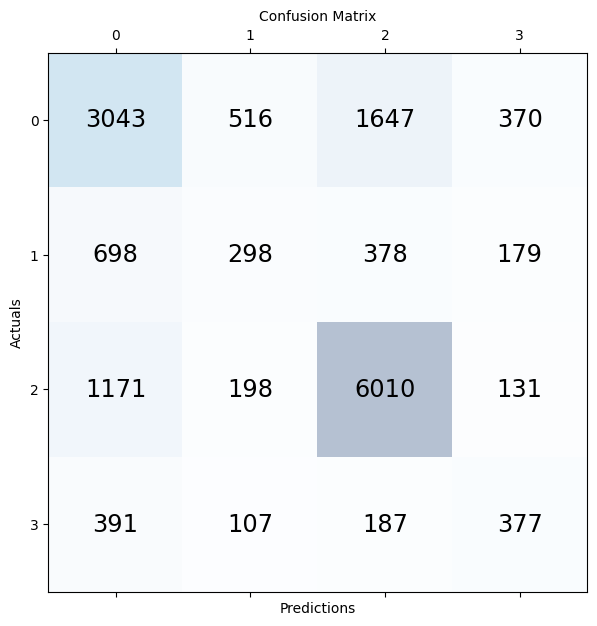

In [30]:
params= trial.params
model = XGBClassifier(
    random_state=42,
    num_class=4,
    n_jobs=-1,
    objective='multi:softmax',
    eval_metric='mlogloss',
    tree_method='gpu_hist',  # Use GPU acceleration
    gpu_id=0,                # Specify GPU device 0
    **params
)

smote=SMOTE(random_state=42, sampling_strategy='not majority')
pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', best_model)
    ])

all_true_labels, all_predicted_labels= cross_validate_with_pipeline(pipeline,X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])